# Plot matern correlation lengths

In [147]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
from xmitgcm import open_mdsdataset,utils
from MITgcmutils import rdmds, wrmds
from xgcm import Grid
import ecco_v4_py

import pych.ecco as pe
import pych.pigmachine as pm
import pych.pigmachine.matern as oldmatern

from matern import MaternField

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = SLURMCluster()
cluster.adapt(minimum=0, maximum=10)
client = Client(cluster)
client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41442 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.1.1.4:41442/status,
Dashboard: http://10.1.1.4:41442/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.1.4:40248,Workers: 0
Dashboard: http://10.1.1.4:41442/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
plt.style.use('thesis')

In [113]:
n_range = 5
xi = 1

In [127]:
ds = open_mdsdataset('/scratch2/tsmith/pig-machine/grid/run', iters=None)

In [128]:
data = rdmds(f'/scratch2/tsmith/pig-machine/interp_obcs/maternC/run.{n_range:02d}dx.01xi/smooth2Dmean001')
ds['smooth2Dmean001'] = xr.DataArray(data, coords=ds.hFacC.isel(XC=0).coords, dims=ds.hFacC.isel(XC=0).dims)

data = rdmds(f'/scratch2/tsmith/pig-machine/interp_obcs/maternC/run.{n_range:02d}dx.01xi/smooth2Dnorm001')
ds['smooth2Dnorm001'] = xr.DataArray(data, coords=ds.hFacC.isel(XC=0).coords, dims=ds.hFacC.isel(XC=0).dims)

In [129]:
data = rdmds(f'/scratch2/tsmith/pig-machine/interp_obcs/maternC/run.{n_range:02d}dx.01xi/smooth2Dfld001')
sample = xr.DataArray(np.arange(1_000), coords={'sample': np.arange(1_000)}, dims=('sample',))
coords = {'sample':sample, 'Z':ds.Z, 'YC':ds.YC}
ds['smooth2Dfld001'] = xr.DataArray(data, coords=coords, dims=tuple(coords.keys()))

In [130]:
with xr.set_options(keep_attrs=True):
    
    ds['variance'] = 1/ds['smooth2Dnorm001']**2
    ds['sigma'] = 1/ds['smooth2Dnorm001']
    ds['ginv_norm'] = (ds['smooth2Dfld001'] * ds['smooth2Dnorm001'] ).where(ds.maskC.isel(XC=0))
    
    ds['variance'].attrs = {'label':r'$\hat{\sigma}^2$'}
    ds['sigma'].attrs = {'label':r'$\hat{\sigma}$'}

In [131]:
# lets get this party started
for key in ['ginv_norm', 'maskC', 'smooth2Dmean001']:
    ds[key] = ds[key].persist()

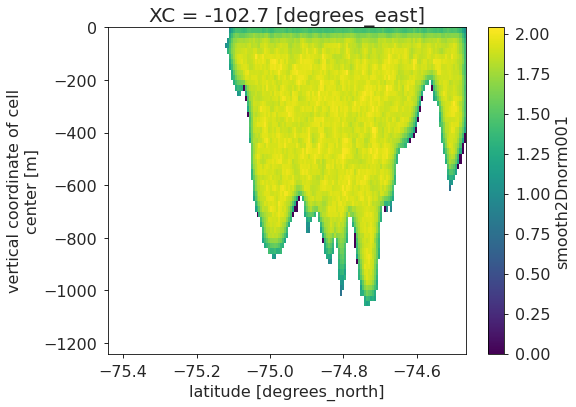

In [138]:
#ds.smooth2Dfld001.isel(sample=0).where(ds.maskC.isel(XC=0)).plot()
ds.smooth2Dnorm001.where(ds.maskC.isel(XC=0)).plot()

### Correlation lengths

In [119]:
import dask.array as darray

In [161]:
def calc_correlation_field(xda, mask, sample_mean,
                           dimlist=('k',),
                           n_shift=15):
    xds = xr.Dataset()
    shifty = np.arange(-n_shift,n_shift+1)
    shifty = xr.DataArray(shifty,coords={'shifty':shifty},dims=('shifty',))
    xds['shifty'] = shifty
    
    # Do this part once
    x_deviation = (xda.data - sample_mean.data[None]).persist()
    x_ssr_inv = (1/np.sqrt( darray.nansum(x_deviation**2, axis=0) )).persist()
    
    dim=dimlist[0]
    assert dim != 0
    
    axis = xda.dims.index(dim)
    
    avg_corr = []
    std_corr = []
    for s in shifty.values:
        avg,std = _calc_shifted(x_deviation, x_ssr_inv, int(s), axis)
        avg_corr.append(avg)
        std_corr.append(std)
        
    # Package it up
    coords = {'shifty':shifty, dim:xda[dim]}
    dims = tuple(coords.keys())
    avg_corr = xr.DataArray(darray.stack(avg_corr, axis=0).persist(),
                            coords=coords,
                            dims=dims)
                            
    std_corr = xr.DataArray(darray.stack(std_corr, axis=0).persist(),
                            coords=coords,
                            dims=dims)
    return avg_corr, std_corr

def _calc_shifted(xdev, xssrinv, n_shift, axis):
    
    y_deviation = _shift(xdev, axis=axis, n_shift=n_shift)
    numerator = darray.nansum(xdev*y_deviation, axis=0)
    y_ssr = np.sqrt( darray.nansum(y_deviation**2, axis=0))
    full_field = numerator / y_ssr * xssrinv
    
    sum_dims = tuple(x for x in range(xdev.ndim-1) if x != axis-1)
    avg = darray.nanmean(full_field, axis=sum_dims)
    std = np.nanstd(full_field, axis=sum_dims)
    return avg, std

def _shift(array, axis, n_shift, fill_value=np.nan):
    result = darray.roll(array, n_shift, axis=axis)
    result = result.rechunk({axis:None})
    if n_shift>=0:
        result[:n_shift] = fill_value
    else:
        result[n_shift:] = fill_value
    return result

def _print(name, array):
    print(f"{name}")
    print(f"\t{array.shape}")
    print(f"\t{array.chunksize}")
    print()
    return

In [162]:
# Compute approximate correlation
avg_k, std_k = calc_correlation_field(ds['ginv_norm'],
                               mask=ds['maskC'].isel(XC=0),
                               sample_mean=ds['smooth2Dmean001'],
                               dimlist=('Z',),
                               n_shift=2*xi*n_range)

In [163]:
cdsd={}
cdsd[n_range] = {}
cdsd[n_range]['avg_corr_z'] = avg_k
cdsd[n_range]['std_corr_z'] = std_k

In [164]:
from copy import deepcopy

In [165]:
mf = MaternField(ds.maskC.isel(XC=0), n_range=n_range, horizontal_factor=xi)

# Compute prediction
cdsd[n_range]['dist'] = np.abs(cdsd[n_range]['avg_corr_z'].shifty)
cdsd[n_range]['delta_zhat'] = deepcopy(cdsd[n_range]['dist']) #.copy(deep=True)
cdsd[n_range]['oldideal_z'] = oldmatern.corr_iso(cdsd[n_range]['dist'], Nx=n_range, ndims=2)#mf.ideal_correlation(distance=cdsd[n_range]['delta_zhat'])
cdsd[n_range]['ideal_z'] = mf.ideal_correlation(distance=cdsd[n_range]['delta_zhat'])

In [166]:
shifty=avg_k.shifty
empirical_k = (1/ds.drF).broadcast_like(avg_k['shifty']).copy()
for s in avg_k.shifty.values:
    empirical_k.loc[{'shifty':s}] *= np.abs(ds['Z'].shift({'Z':s}) - ds['Z'])

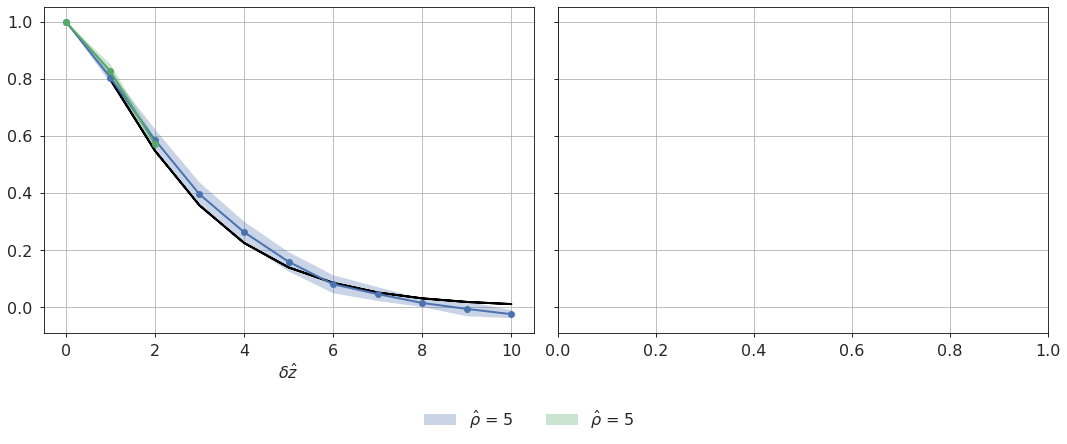

In [170]:
ncols = 2
nrows = 1

fig,axs = plt.subplots(nrows,ncols,figsize=(18,6*nrows),
                       sharey=True)

for dim,stopper,ax in zip(['Z'],[xi,1],axs):
    for Nx,xds in cdsd.items():
        
        #label = 'Predicted' if dim == 'YC' and Nx == 5 else None
        label = r'$r\,(\hat{\rho},||\hat{x}_1-\hat{x}_2||)$' if dim == 'i' and Nx ==5 else None
        
        #xds = xds.sel(shifty=slice(0,2*stopper*Nx))
        xaxis = xds['delta_zhat']
        
        plotme=xds[f'ideal_{dim.lower()}']
        #plotme.plot(ax=ax,label=label,color='black')
        ax.plot(xaxis, plotme,label=label,color='black')
    
        fld = f'corr_{dim.lower()}'
        
        #label=r'Domain avg $\pm \sigma$'
        label=r'$\hat{\rho}$ = %d' % Nx
        label = label if dim == 'Z' else None
        for condition in [shifty>=0, shifty<=0]:
            
            kk=50
            x = np.abs(empirical_k.isel(Z=kk).where(condition))
            yavg = xds[f"avg_{fld}"].isel(Z=kk).where(condition)
            ystd = xds[f"std_{fld}"].isel(Z=kk).where(condition)
            ax.plot(x,yavg,marker='o')
            
            ax.fill_between(x,yavg-ystd, yavg+ystd,
                            alpha=.3,
                            label=label)
    
    #text = '(a) Latitude' if dim == 'YC' else '(b) Depth'
    #ax.text(-12.5,.9,text,ha='center')
        
    ax.set(xlabel=r'$\delta\hat{%s}$'%dim[0].lower(),ylabel='',title='')
    if dim == 'i':
        ax.set_ylabel('Correlation')
        
fig.subplots_adjust(wspace=.05)
fig.legend(ncol=5,
           loc='center',
           bbox_to_anchor=(.5,-0.075),
           frameon=False)
#fig.savefig(f'{fig_dir}/nondimensional_correlation.pdf',bbox_inches='tight',dpi=300)

In [52]:
empirical_k.isel(Z=20)

<xarray.DataArray 'drF' (shifty: 21)>
array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,
        3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
Coordinates:
    Z        >f8 -410.0
    drF      >f8 20.0
    PHrefC   >f8 4.022e+03
    rhoRef   >f8 1.03e+03
  * shifty   (shifty) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 2 3 4 5 6 7 8 9 10

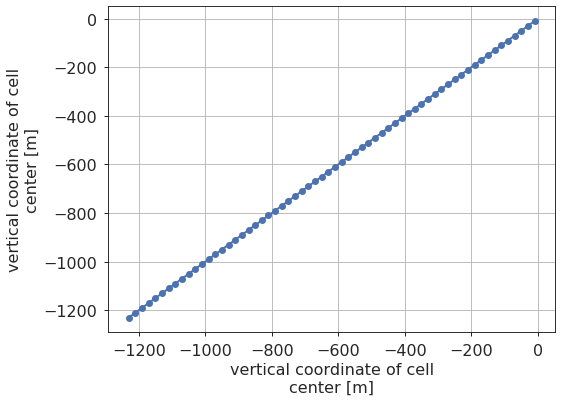

In [51]:
ds.Z.plot(marker='o')

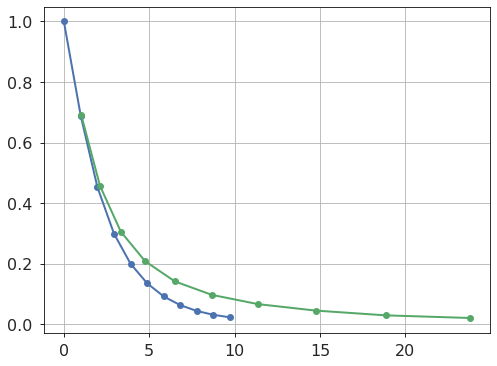

In [155]:
plt.plot(empirical_k.sel(k=kk).where(avg_k.shifty>=0), xds[f'avg_{fld}'].sel(k=kk).where(avg_k.shifty>=0),marker='o')
plt.plot(empirical_k.sel(k=kk).where(avg_k.shifty<0), xds[f'avg_{fld}'].sel(k=kk).where(avg_k.shifty<0),marker='o')

In [153]:
(xds[f"avg_{fld}"]).sel(k=kk).values

array([0.02105688, 0.02969656, 0.04550158, 0.06676243, 0.09744574,
       0.1418071 , 0.20836593, 0.30595538, 0.45731333, 0.6899638 ,
       1.        , 0.68821245, 0.45300522, 0.2993827 , 0.20020781,
       0.13582243, 0.09226362, 0.06369501, 0.04429802, 0.03165197,
       0.02323563], dtype=float32)

In [133]:
empirical_k.sel(k=20).values

array([15.542818 , 13.731364 , 11.935909 , 10.164727 ,  8.432545 ,
        6.758546 ,  5.164636 ,  3.673273 ,  2.3052728,  1.0772727,
        0.       ,  0.9227272,  1.6947271,  2.326727 ,  2.8353634,
        3.2414544,  3.5674543,  3.8352723,  4.064182 ,  4.2692723,
        4.4612727], dtype=float32)

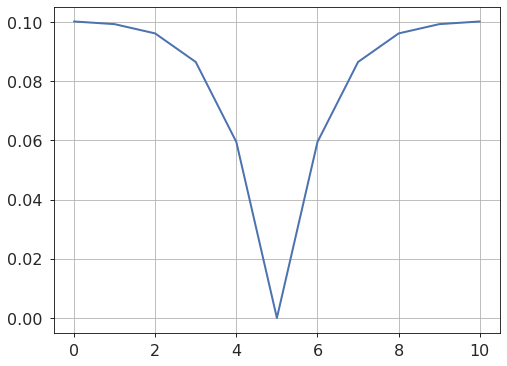

In [22]:
plt.plot(cdsd[5]['std_corr_k'])

## First, show a plot of some samples

In [11]:
def add_arrows(ax,Nx,xi=1):
    
    yc = float(ds.YC.sel(YC=-74.58,method='nearest'))
    yind = list(ds.YC.values).index(yc)
    
    zc = float(ds.Z.sel(Z=-800,method='nearest'))
    zind = list(ds.Z.values).index(zc)
    
    Nx0 = int(np.floor(Nx/2*xi))
    Nx1 = int(np.ceil(Nx/2*xi))
    y0 = float(ds.YC[yind-Nx0])
    y1 = float(ds.YC[yind+Nx1])
    
    Nx0 = int(np.floor(Nx/2))
    Nx1 = int(np.ceil(Nx/2))
    z0 = float(ds.Z[zind-Nx0])
    z1 = float(ds.Z[zind+Nx1])
    
    # Up and down
    arrowprops = {'width':1,'color':'white'}
    if Nx<10 and xi==1:
        arrowprops['headlength'] = 8
        arrowprops['headwidth'] = 5
    
    half = float(ds.YC.diff('YC').mean()/2) if Nx0!=Nx1 and xi!=2 else 0
    ax.annotate(text='',xy=(yc+half,z0),xytext=(yc+half,z1),
                arrowprops=arrowprops)
    ax.annotate(text='',xytext=(yc+half,z0),xy=(yc+half,z1),
                arrowprops=arrowprops)
    
    arrowprops['headlength'] = 8
    if Nx<=10 and xi == 1:
        arrowprops['headlength'] = 3
        arrowprops['headwidth'] = 5
        
    half = float(ds.Z.diff('Z').mean()/2) if Nx0!=Nx1 else 0
    ax.annotate(text='',xy=(y0,zc+half),xytext=(y1,zc+half),
                arrowprops=arrowprops)
    ax.annotate(text='',xytext=(y0,zc+half),xy=(y1,zc+half),
                arrowprops=arrowprops)

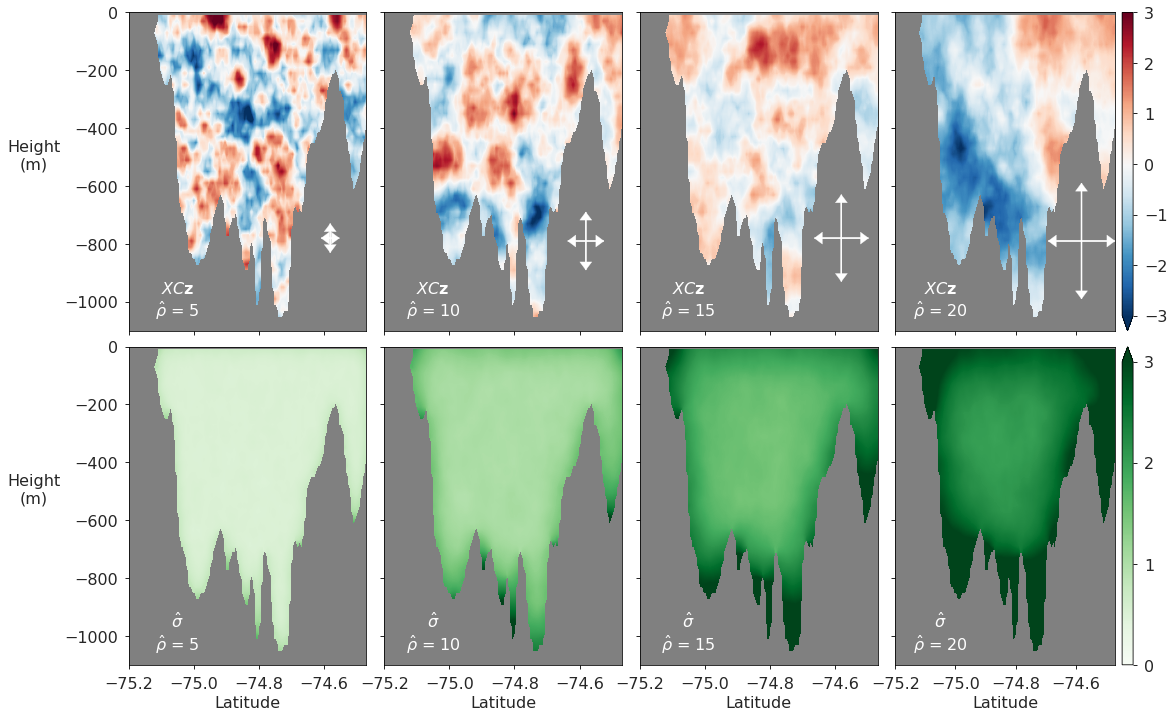

In [12]:
ncols = len(dsd.keys())
nrows = 2
fig,axs = plt.subplots(nrows,ncols,figsize=(18,6*nrows),
                       sharey=True, sharex=True)

for fld,cmap,vmax,vmin,axr in zip(['ginv_norm','sigma'],
                               ['RdBu_r','Greens'],
                               [3,3],
                                    [-3,0],
                                axs):
    
    for (Nx,xds),ax in zip(dsd.items(),axr):
        plotme = xds[fld].sel(sample=60) if 'sample' in xds[fld].dims else xds[fld]
        plotme = plotme.where(tw.mask)
        p = plotme.plot.contourf(ax=ax,vmax=vmax,vmin=vmin,
                                 add_colorbar=False,
                                 levels=250,
                                 cmap=cmap)
        # labels
        ax.set(ylabel='',xlabel='',title='',
               xlim=[-75.2,None],ylim=[-1100,0])
        if ax.get_subplotspec().colspan[0]==0:
            ax.set_ylabel('Height\n(m)',labelpad=30,rotation=0)
        if ax.get_subplotspec().rowspan[-1]==nrows-1:
            ax.set_xlabel('Latitude')
        ax.grid(False)
        text = plotme.label + '\n'
        text += r'$\hat{\rho}$ = %d' % Nx
        ax.text(-75.05,-1050,text,
                ha='center',color='white')
        
        ax.add_patch(plt.Rectangle((ax.get_xlim()[0],ax.get_ylim()[0]),
                                   ax.get_xlim()[1]-ax.get_xlim()[0],
                                   ax.get_ylim()[1]-ax.get_ylim()[0],
                                   facecolor='gray',
                                   zorder=0)
                                )
        
        if fld == 'ginv_norm':
            add_arrows(ax,Nx,xi=xi)
            
    # Now, add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    ticks = np.linspace(-3,3,7)
    fig.colorbar(p,cax=cax,ticks=ticks)
        
fig.subplots_adjust(wspace=.075,hspace=.05)
#fig.savefig(f'{fig_dir}/samples_and_pointwise_std.jpg',bbox_inches='tight',dpi=300)

### For defense, just two correlation length scale plots

In [13]:
def remove_tickstuff(ax):
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) 

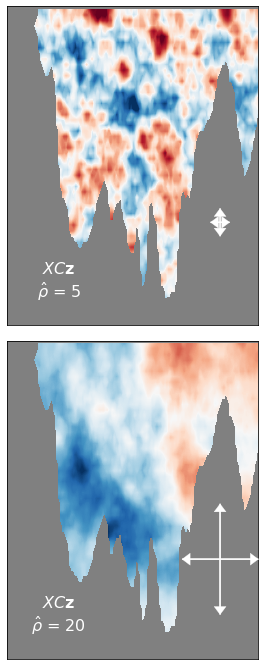

In [14]:
ncols = 1
nrows = 2
fig,axs = plt.subplots(nrows,ncols,figsize=(18/4,6*nrows),
                       sharey=True, sharex=True)

fld = 'ginv_norm'
cmap = 'RdBu_r'
vmax = 3
vmin = -3
for Nx,ax in zip([5,20],axs):
    
    plotme = dsd[Nx][fld].sel(sample=60)
    plotme = plotme.where(tw.mask)
    
    p = plotme.plot.contourf(ax=ax,vmax=vmax,vmin=vmin,
                             add_colorbar=False,
                             levels=250,
                             cmap=cmap)
    ax = pm.fix_obcsw_plot(ax)
    text = plotme.label + '\n'
    text += r'$\hat{\rho}$ = %d' % Nx
    ax.text(-75.05,-1050,text,
            ha='center',color='white')
    
    # Make it clean for big fig
    remove_tickstuff(ax)
    ax.set(xlabel='',ylabel='')
        
    # Add those arrows
    add_arrows(ax,Nx,xi=xi)
            
fig.subplots_adjust(wspace=.075,hspace=.05)
#fig.savefig(f'{fig_dir}/two_correlation_samples.jpg',bbox_inches='tight',dpi=300)

### Also for defense: compare to isotropic

In [15]:
iso = {}
for Nx in [20,100,200,600]:
    ds = pm.matern.get_matern_dataset(f'/scratch2/tsmith/pig-machine/isotest/maternC.isotropic/run.{Nx:02}dx.{xi:02}xi',
                                      smoothOpNb=smoothOpNb,
                                      xdalike=tw.mask.sortby('Z',ascending=False),
                                      sample_num=range(1000),
                                      read_filternorm=True)
    ds = ds.sortby('Z')
    ds['variance'] = 1/ds['filternorm']**2
    ds['sigma'] = 1/ds['filternorm']
    
    ds['ginv_norm'].attrs = {'label':r'$XC\mathbf{z}$'}
    ds['variance'].attrs = {'label':r'$\hat{\sigma}^2$'}
    ds['sigma'].attrs = {'label':r'$\hat{\sigma}$'}
    iso[Nx] = ds

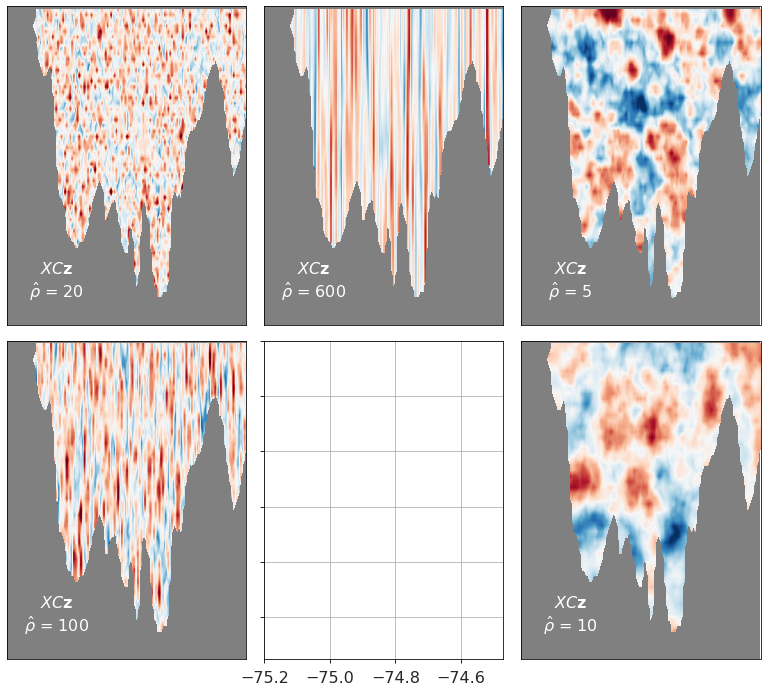

In [57]:
ncols = 3
nrows = 2
fig,axs = plt.subplots(nrows,ncols,figsize=(18/4*3,6*nrows),
                       sharey=True, sharex=True)

fld = 'ginv_norm'
cmap = 'RdBu_r'
vmax = 3
vmin = -3

for mydict, keys, axr in zip([iso,iso,dsd],
                             [[20,100], [600,],[5,10]],
                             [axs[:,0].flatten(), axs[:,1].flatten(),axs[:,2].flatten()]):
    for Nx,ax in zip(keys,axr):
        
        plotme = mydict[Nx][fld].sel(sample=60)
        plotme = plotme.where(tw.mask)
        
        p = plotme.plot.contourf(ax=ax,vmax=vmax,vmin=vmin,
                                 add_colorbar=False,
                                 levels=250,
                                 cmap=cmap)
        ax = pm.fix_obcsw_plot(ax)
        text = plotme.label + '\n'
        text += r'$\hat{\rho}$ = %d' % Nx
        ax.text(-75.05,-1050,text,
                ha='center',color='white')
        
        # Make it clean for big fig
        remove_tickstuff(ax)
        ax.set(xlabel='',ylabel='')
            
        # Add those arrows
        #add_arrows(ax,Nx,xi=xi)
            
fig.subplots_adjust(wspace=.075,hspace=.05)

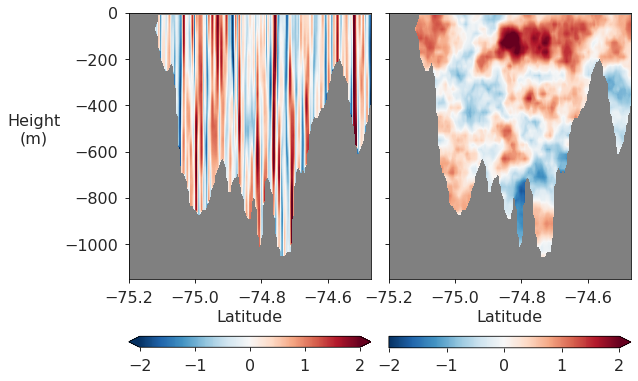

In [36]:

ncols = 2
nrows = 1

# Ok ... just going to iterate through and make each separately
fig,axs = plt.subplots(nrows,ncols,figsize=(18/2,7*nrows),
                       sharey=True, sharex=True)

fld = 'ginv_norm'
cmap = 'RdBu_r'
vmax = 2
vmin = -2

cbkw = {'ticks':np.linspace(vmin,vmax,5),
        'orientation':'horizontal',
        'label':'',
        }
        
for ii,(xda, ax) in enumerate(zip([iso[600],dsd[15]],axs.flatten())):
        
    plotme = xda[fld].sel(sample=60)
    plotme = plotme.where(tw.mask)
    
    p = plotme.plot.contourf(ax=ax,vmax=vmax,vmin=vmin,
                             levels=250,
                             cmap=cmap,
                             cbar_kwargs=cbkw)
        
    ax = pm.fix_obcsw_plot(ax)
    ax.set(xlabel='Latitude')
    
axs[-1].set(ylabel='')
# Now, add colorbar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='5%', pad=0.1)
#ticks = np.linspace(vmin,vmax,7)
#fig.colorbar(p,cax=cax,ticks=ticks)
            
fig.subplots_adjust(wspace=.075,hspace=.05)
fig.savefig(f'{fig_dir}/isotropic_vs_anisotropic_forms.jpg', dpi=300, bbox_inches='tight')

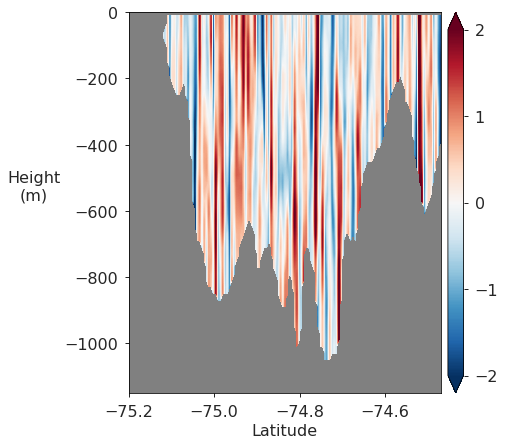

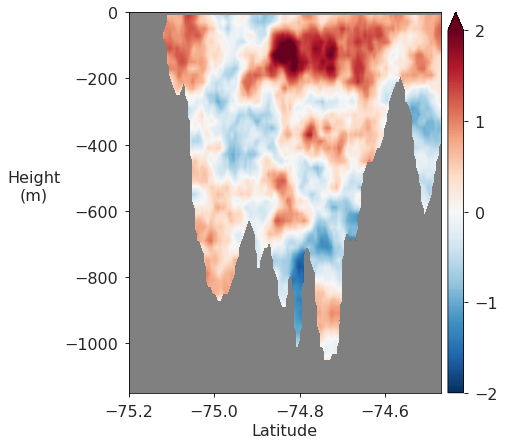

In [57]:
fld = 'ginv_norm'
cmap = 'RdBu_r'
vmax = 2
vmin = -2
cbkw = {'ticks':np.linspace(vmin,vmax,5),
        'orientation':'vertical',
        'label':'',
        }

for plotnum,xda in enumerate([iso[600],dsd[15]]): 
    
    fig,ax = plt.subplots(figsize=(6,7))
    plotme = xda[fld].sel(sample=60)
    plotme = plotme.where(tw.mask)
    p = plotme.plot.contourf(ax=ax,vmax=vmax,vmin=vmin,
                             levels=250,
                             cmap=cmap,
                             add_colorbar=False)
        
    ax = pm.fix_obcsw_plot(ax)
    ax.set(xlabel='Latitude')
    
    # Now, add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    ticks = np.linspace(vmin,vmax,5)
    fig.colorbar(p,cax=cax,ticks=ticks)
    
    fig.savefig(f'{fig_dir}/isotropic_vs_anisotropic_forms{plotnum}.jpg', dpi=300, bbox_inches='tight')

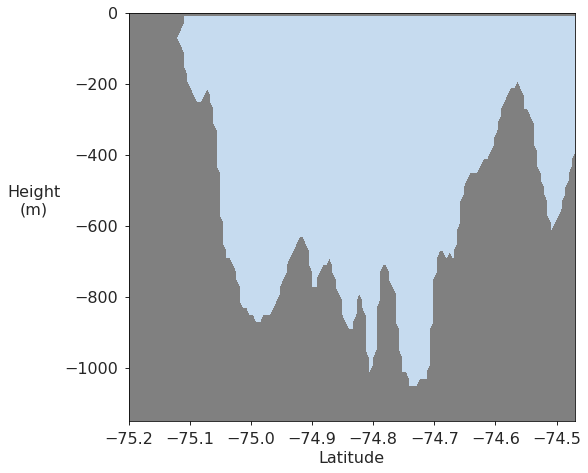

In [50]:
# Ok ... just going to iterate through and make each separately
fig,ax = plt.subplots(figsize=(8,7.5))

plotme = 0*xds['ginv'].isel(sample=0).where(tw.mask)
plotme.plot.contourf(ax=ax,vmax=2,vmin=-1,levels=10,cmap='Blues',
            add_colorbar=False)
ax = pm.fix_obcsw_plot(ax)
fig.savefig(f'{fig_dir}/blue_open_boundary.jpg',dpi=300,bbox_inches='tight')
#ax.tick_params(labelleft=False,labelbottom=False)
#fig.subplots_adjust(wspace=.075,hspace=.05)
#fig.savefig(f'{fig_dir}/isotropic_vs_anisotropic_forms.jpg', dpi=300, bbox_inches='tight')

### Compute correlation lengths

Compute the Pearson's Correlation Coefficient for a sample (the 1000 random samples being the statistical sample 
size).
This is the covariance normalized by the standard deviations at each location.

$$ r_{xy} =
    \dfrac{\sum_{i=1}^{N} (x_i - \bar{x})(y_i - \bar{y})}
            {\sqrt{ \sum_{i=1}^{N}(x_i-\bar{x})^2}
             \sqrt{ \sum_{i=1}^{N}(y_i-\bar{y})^2}}
$$ 

where I'm calling $x$ the values of the centered dataset, $y$ is shifted in either direction.

In [ ]:
mf.ide

/home/tsmith/pych/pych/ecco/llcmap.py:65: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color='gray',alpha=.6)


<GeoAxesSubplot:>

/scratch2/tsmith/miniconda3/envs/py38_tim/lib/python3.8/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


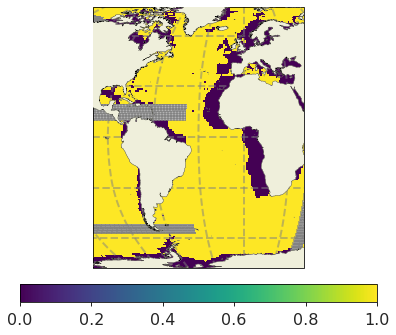

In [29]:
llcmap((1*tw.mask).shift({'i':-10}).isel(k=0))

In [30]:
cdsd = {}
for Nx in dsd.keys():
    # Compute approximate correlation
    cdsd[Nx] = pm.matern.calc_correlation_field(dsd[Nx]['ginv_norm'],
                                                mask=tw.mask,n_shift=xi*2*Nx)
    
    # Compute prediction
    cdsd[Nx]['dist'] = np.abs(cdsd[Nx].shifty)
    cdsd[Nx]['delta_yhat'] = cdsd[Nx]['dist'] / xi
    cdsd[Nx]['delta_zhat'] = cdsd[Nx]['dist'].copy(deep=True)
    cdsd[Nx]['predicted_yc'] = pm.matern.corr_iso(cdsd[Nx].delta_yhat, Nx, ndims=2)
    cdsd[Nx]['predicted_z'] = pm.matern.corr_iso(cdsd[Nx].delta_zhat, Nx, ndims=2)

ValueError: Invalid value for `pad_width`

### Plot specific points

In [51]:
pt1 = {'YC':-74.75, 'Z':-500}
pt2 = {'YC':-75, 'Z':-500}
pt3 = {'YC':-75.03, 'Z':-500}
ptlist = [pt1,pt2,pt3]

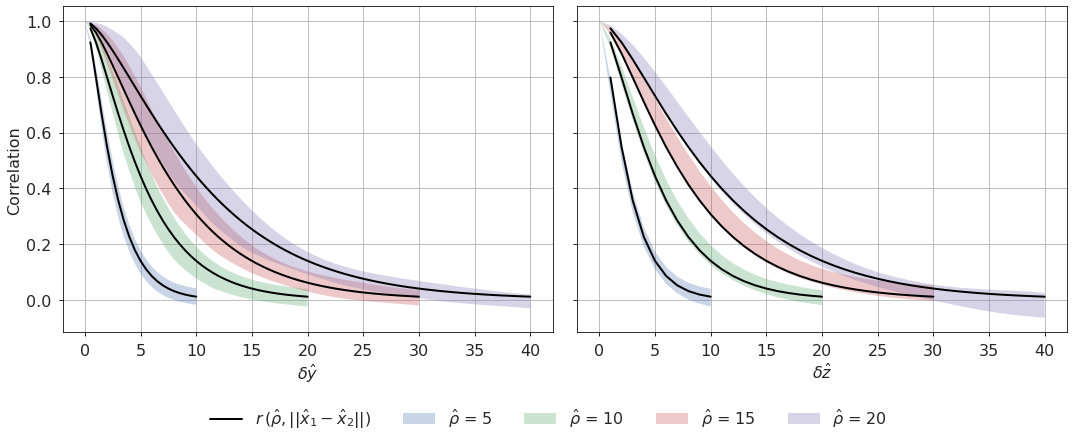

In [60]:
ncols = 2
nrows = 1

fig,axs = plt.subplots(nrows,ncols,figsize=(18,6*nrows),
                       sharey=True)

for dim,stopper,ax in zip(['YC','Z'],[xi,1],axs):
    for Nx,xds in cdsd.items():
        
        #label = 'Predicted' if dim == 'YC' and Nx == 5 else None
        label = r'$r\,(\hat{\rho},||\hat{x}_1-\hat{x}_2||)$' if dim == 'YC' and Nx ==5 else None
        
        xds = xds.sel(shifty=slice(0,2*stopper*Nx))
        xaxis = xds.delta_yhat if dim == 'YC' else xds.delta_zhat
        
        plotme=xds[f'predicted_{dim.lower()}']
        #plotme.plot(ax=ax,label=label,color='black')
        ax.plot(xaxis, plotme,label=label,color='black')
    
        fld = f'corr_{dim.lower()}'
        domain_avg = xds[fld].mean(['YC','Z'])
        domain_std = xds[fld].std(['YC','Z'])
        
        #label=r'Domain avg $\pm \sigma$'
        label=r'$\hat{\rho}$ = %d' % Nx
        label = label if dim == 'YC' else None
        ax.fill_between(xaxis,
                        domain_avg-domain_std,
                        domain_avg+domain_std,
                        alpha=.3,
                        label=label)
    
    #text = '(a) Latitude' if dim == 'YC' else '(b) Depth'
    #ax.text(-12.5,.9,text,ha='center')
        
    ax.set(xlabel=r'$\delta\hat{%s}$'%dim[0].lower(),ylabel='',title='')
    if dim == 'YC':
        ax.set_ylabel('Correlation')
        
fig.subplots_adjust(wspace=.05)
fig.legend(ncol=5,
           loc='center',
           bbox_to_anchor=(.5,-0.075),
           frameon=False)
fig.savefig(f'{fig_dir}/nondimensional_correlation.pdf',bbox_inches='tight',dpi=300)

### Note that the x-axis in this plot needs to be updated to be $\delta\hat{y}$ and $\delta\hat{z}$

In [52]:
#nrows=2
#ncols=len(cdsd.keys())
#fig,axs = plt.subplots(nrows,ncols,figsize=(18,5*nrows))
#
#for dim,axr in zip(['YC','Z'],axs):
#    for (Nx,xds),ax in zip(cdsd.items(),axr):
#        fld = f'corr_{dim.lower()}'
#        plotme = xds[f'predicted_{dim.lower()}']
#        plotme.plot(ax=ax,label=None,color='black')
#        
#        for pt in ptlist:
#            plotme = xds[fld].sel(**pt,method='nearest')
#            label = r'%.2f$^\circ$W, %d m' % (float(np.abs(plotme.YC)),float(np.abs(plotme.Z)))
#            label = label if dim == 'YC' and Nx == 20 else None
#            plotme.plot(ax=ax,label=label)
#        
#        text = '(a) Latitude' if dim == 'YC' else '(b) Depth'
#        #ax.text(-12.5,.9,text,ha='center')
#        
#        ax.set(xlabel=r'$\hat{\rho}$',ylabel='',title='')
#        if dim == 'YC' and Nx==5:
#            ax.set_ylabel('Correlation')
#        
#fig.legend(title='Latitude, Depth',ncol=3,
#           loc='center',
#           bbox_to_anchor=(.5,-.1),
#           frameon=False)

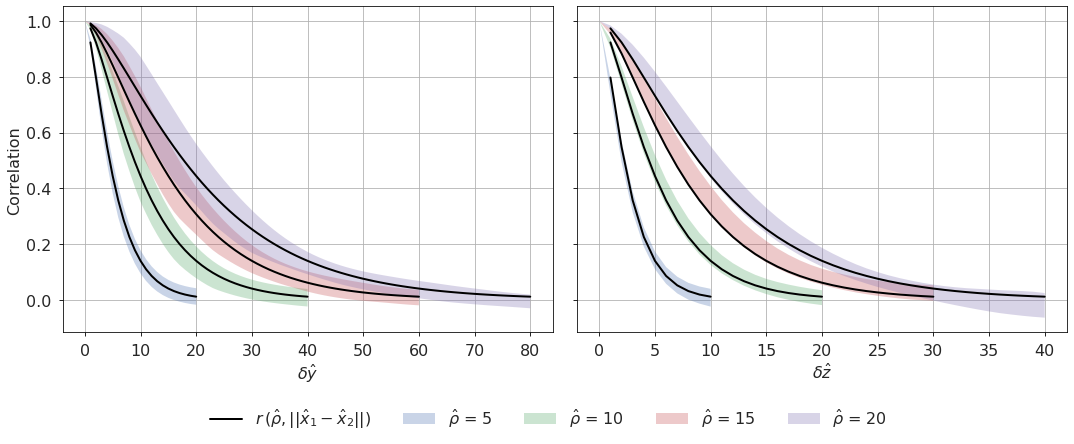